# Location Dimension ETL

## Introduction

In this dimension we old information, of all possible locations.

### Schema

![ETL Host](images/location_schema.png)

The schema was in general maintained, with the addition of one new column, street_type. This column is extracted from official CTT documents, and so no processing is required. This column its a categorical value that describes the type of street for a certain location, some possible values are: Rua; Estrada Nacional; Praça; etc.

### Hierarchies and data granularity

In this dimension, all columns share relationships between them, since we are dealing with data that describes a physical location, mainly address information.

It exists the following hierarchical chain: `Street` < `Parish` < `County`. These columns represent main components of the location's address, and so, obviously, share an hierarchical relationship, expressed in physical land boundaries.

The columns `Street_Type`; `Zip_Code`; `Coastal_Area` share relationships with all other columns, and between them, although they are not, at least directly, hierarchical. They are extra attributes, that hold information on a specific location.

We decided to use `Street` as our finner grain, since we want locations to generalized to more them one fact (one-to-many relationship). Any finner grain would compromise this objective.

### ETL Process

![ETL Host](images/Pipeline_Location.png)

In this ETL process, we add to take house specific address, and parse them to find the general street they describe. To this end we used a mixture of the open source NLP tools and case specific parsing functions. 

Unfortunately, there are no available tools for parsing Portuguese addresses specifically. So we coupled an Open Source library (`libpostal`), with some case specific logic, to solve issues we detected when trying to use the tool to parse Portuguese addresses. But since this field is open text, its impossible to deal with all possible address in this manner. To do this correctly in a production environment, an NLP model should be trained to identify generic streets in Portuguese addresses. We could even use `libpostal` as pretrained model, and them specify the model with Portuguese addresses specific training.

Right now we are able to obtain a semi-optimal result for all locations, with some streets more generalized them others. In the mapping phase we address possible duplicates, by checking if any street can be considered a subset of another street, and if they share a similar zip code. 

### Slow Changing Dimension

**Locations are not expected to change.** New locations can be added and Facts can map to different dimensions. But since we deal with general locations (street level), we don't expect them to change, and always want them to exist. Even if a certain location is not being used by any fact at a given time, it can always be mapped to a new fact. New facts will always try to map to existing locations, so existing locations will always be useful.

Changes might be needed in very exceptional situations like, changes in: County/Parish name/boudaries; Street name; Portuguese Postal system. So mainly changes that might never happen.

In light of this, we consider this to be a **slow changing dimension of type I**, where if changes are required, specific SQL would be written to perform bulk updates to the DBs. For example in case county A and county B become county C, we would need to update all locations to that are in counties A or B to county C. 

In this ETL we don't consider this changes, since they are too sporadic, and can differ a lot given their origin.

We choose to model these changes as type I, because we don't see any major advantage of having a record of this changes.

## Part 0 - Listings|Location - EDA

### Library and Function Imports

In [1]:
# Import Libs

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm


In [2]:
# Load Functions

def missing_data(df, columns):
    df_graph = df[columns]
    #missing data
    total = df_graph.isnull().sum().sort_values(ascending=False)
    percent = (df_graph.isnull().sum()/df_graph.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data)
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='index',y = 'Percent', data= missing_data.reset_index())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

def feature_dist(df, column_name):
    plt.figure(figsize=(15,4))
    sns.distplot(df[column_name] , fit=norm)

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[column_name])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('{} distribution'.format(column_name))
    plt.show()

#IN BAR CHARTS, SET PERCENTAGES ABOVE EACH BAR
def set_bar_percentage(ax, df):
    for p in ax.patches:
        ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
          ha='center', va='center', rotation=0, xytext=(0, 10),
          textcoords='offset points')
        
#IN BAR CHARTS, SET THE VALUE ABOVE EACH BAR
def set_bar_amount(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate("{0:.2f}%".format(p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', rotation=0, xytext=(0, 10),
            textcoords='offset points')
        
#Simple plot
def simple_plot(df,column):
    bx = sns.catplot(x=column,data=df, kind='count')
    (bx.set_axis_labels(column, "Count")
        .set_titles("{col_name} {col_var}")
        .despine(left=True))
    
def intTryParse(value):
    try:
        a = int(value)
        return True
    except ValueError:
        return False

### Load Data

In [3]:
#Load CSV files

df_result = pd.read_csv("../data/listings_al.csv", low_memory=False)
df_result.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,UNESCO,Geoparques,Biosfera,ConcessaoTuristica,PNCT,concelhoRNAL,EstacaoNautica,RedeAldeias,FreguesiasCosteiras,NUTSIIICosteiras
0,25659,https://www.airbnb.com/rooms/25659,2.020010e+13,1/28/2020,"Sunny, Alfama Sleeps 3 - Coeur d'Alfama",Sunny 1 Bedroom cozy apartment in historic Alf...,"Charming, sunny, cozy apartment in the heart o...",Sunny 1 Bedroom cozy apartment in historic Alf...,none,Alfama is the oldest and most picturesque quar...,...,Não Abrangido,Não Abrangido,Não Abrangido,Não Abrangido,Não Abrangido,Lisboa,Não Abrangido,Não Abrangido,Sim,Sim
1,29248,https://www.airbnb.com/rooms/29248,2.020010e+13,1/28/2020,Apartamento Alfama com vista para o rio!,NaN,"Located in the city center, and great location...","Located in the city center, and great location...",none,NaN,...,Não Abrangido,Não Abrangido,Não Abrangido,Não Abrangido,Não Abrangido,Lisboa,Não Abrangido,Não Abrangido,Sim,Sim
2,29396,https://www.airbnb.com/rooms/29396,2.020010e+13,1/28/2020,Alfama Hill - Boutique apartment,Feel at home in the historic centre of Lisbon.,"Charming apartment renovated in 2017, on the g...",Feel at home in the historic centre of Lisbon....,none,Great neighborhood in the old part of town. Am...,...,Não Abrangido,Não Abrangido,Não Abrangido,Não Abrangido,Não Abrangido,Lisboa,Não Abrangido,Não Abrangido,Sim,Sim
3,29720,https://www.airbnb.com/rooms/29720,2.020010e+13,1/28/2020,TheHOUSE - Your luxury home,"A house at the top of an anonimous building, T...","The size, the decoration and, especially, our ...","A house at the top of an anonimous building, T...",none,"Location in the city's Embassies area, near en...",...,Não Abrangido,Não Abrangido,Não Abrangido,Não Abrangido,Não Abrangido,Lisboa,Não Abrangido,Não Abrangido,Sim,Sim
4,27899698,https://www.airbnb.com/rooms/27899698,2.020010e+13,1/28/2020,Stylish and spacious apartment in Estrela,Bem-vindos ao TheHOUSE - Apartamento! Preparám...,NaN,Bem-vindos ao TheHOUSE - Apartamento! Preparám...,none,NaN,...,Não Abrangido,Não Abrangido,Não Abrangido,Não Abrangido,Não Abrangido,Lisboa,Não Abrangido,Não Abrangido,Sim,Sim


In [4]:
print('dataset size: {}'.format(len(df_result)))

dataset size: 17168


### Missing Data

                     Total   Percent
CodigoPostal            21  0.001223
FreguesiasCosteiras      0  0.000000
Endereco                 0  0.000000


Text(0.5, 1.0, 'Location dimension missing data')

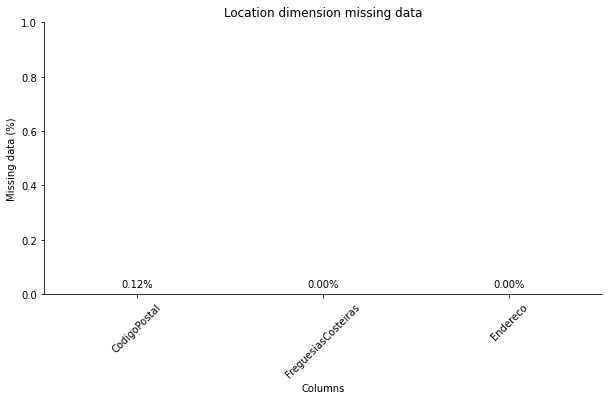

In [5]:
columns = [
    'Endereco',
    'CodigoPostal',
    'FreguesiasCosteiras'
    ]
ax = missing_data(df_result,columns)
set_bar_amount(ax)
ax.set_xlabel('Columns')
ax.set_ylabel('Missing data (%)')
plt.ylim(0,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Location dimension missing data')

**Street**

Some repeated addresses. Reapeated 'Rua'.

In [6]:
print(df_result['Endereco'].value_counts())

1ª Rua José Joaquim Fernandes 76               27
Rua Rua Fradesso da Silveira 79 1º e sotão     25
Rua Rua Fanqueiros 150 3.º                     23
Urbanização Pérola do Oceano 10 Rc D           18
Rua Rua Bicuda                                 16
                                               ..
Rua Rua Jerónimo Vilarinho 28 2º n.13           1
Rua Rua São Paulo 220 1º Dto.                   1
Rua Rua Duque 71 2º                             1
Praça Praça Dom Luís I 30 1 1.28                1
Rua Rua Mãe D'Água 15 3º G                      1
Name: Endereco, Length: 13112, dtype: int64


**Zip_code**

- Some missing values - 21
- Some repeated values

In [7]:
print(df_result['CodigoPostal'].value_counts())

1200-148    60
1100-232    56
1100-376    54
1200-425    40
2655-333    36
            ..
2530-721     1
1495-040     1
1700-201     1
1269-165     1
2560-460     1
Name: CodigoPostal, Length: 4631, dtype: int64


**Coastal Area**

In [8]:
print(df_result['FreguesiasCosteiras'].value_counts())

Sim    16870
Não      298
Name: FreguesiasCosteiras, dtype: int64


## Part 1- Raw Data Processing

**UNIX systems only**

This part uses pypostal, which are python bindings for the libpostal C library.

"Libpostal is a C library for parsing/normalizing street addresses around the world using statistical NLP and open data. The goal of this project is to understand location-based strings in every language, everywhere."

[Follow this instructions to install pypostal](https://github.com/openvenues/pypostal#installation).

### Library and Function Imports

In [18]:
# Import Libs

import re
import pandas as pd
from postal.parser import parse_address
import string
import numpy as np

In [10]:
# Load Functions

def street_parser(s):
    
    s_final = ''
    
    sch = s[:int(len(s)/2)]

    first_digit = re.search(r"\d", sch)
    
    try:
        s = s[:int(first_digit.start() + len(s)/2)]
        
    except AttributeError:
        pass

    s = s.split(' ')
    s = [x.replace(' ', '') for x in s if x != '']

    for ss in s:
        s_final += '{} '.format(ss)
        
    return s_final[:-1]

def is_int(n):
    
    try:
        int(n)
        return True
    
    except ValueError:
        return False
        

def get_street(st, street_str=''):
    
    forbiden = ['DENOMINADO', 'Nº', 'NºS', 'NÚMEROS', 'N.º']
    
    street = parse_address(st)[0][0]
    
    if len(street) <= len(st)/2:
        
        street = street_parser(st)
    
    street = street.split(' ')
    
    for i, s in enumerate(street):
        if s not in street_str:
            if s in forbiden or (i > 3 and any(is_int(si) for si in s)):
                break

            street_str += s + ' '
            
    street_str.translate(str.maketrans('', '', string.punctuation))
            
    return (street_str[:-1])[:100].upper()

def validate_zip(sample, expr=r"(\b\d{4}-\d{3}\b)"):
    
    zipCode = re.compile(expr)

    try:
        if zipCode.match(sample):
            return sample
        else:
            return None
    except TypeError:
        return None
    
def delete_null_rows(df,columns):
    """Removes all records with any empty cells from input DataFrame"""
    processed_df = df[columns].copy()
    total_rows = processed_df.shape[0]
    delete_rows = []
    
    if processed_df.isnull().values.any(): # if there are any null values in DataFrame, process DataFrame
        for index, row in enumerate(processed_df.itertuples(), start = 0):
            if (pd.Series(row).isnull().values.any()): # if row has any null value
                delete_rows.append(index) # add row index to delete list
    
    final_df = df.copy()
    final_df.drop(df.index[delete_rows], inplace = True) # delete rows fr
    final_df = final_df.reset_index().drop('index', axis = 1)
    print("DataFrame contains {} rows. Deleted {} rows ({}% of total rows)".format(
        len(final_df), len(delete_rows), round(len(delete_rows)*100/total_rows, 2)))
    return final_df

def check_zeros(ext, lenght=3):
    
    ext = str(ext)
    
    if len(ext) != lenght:
        
        return '0' * (lenght - len(ext)) + str(ext)
    else:
        return ext
    
def coastal_area(boolean):
    if boolean == 'Sim':
        return 'Coastal Area'
    elif boolean == 'Não':
        return 'Not Coastal Area'
    else:
        return None
    
def map_duplicates(streets, zip_codes, ids):

    temps = []
    dup_id = []
    main_id = []

    for i, entry in enumerate(ids):


        flag = True
        for temp in temps:

            if (streets[i].issubset(temp[0]) or streets[i] == temp[0])  and zip_codes[i][:4] == temp[1][:4]:

                dup_id.append(entry)
                main_id.append(temp[2])

                flag = False
                break

        if flag is True:

            temps.append([streets[i], zip_codes[i], entry])
            dup_id.append(entry)
            main_id.append(entry)
            
    return(dup_id, main_id)

### Load Data

In [11]:
#Import Data

df = pd.read_csv("../data/listings_al.csv", low_memory=False)
df_cp = pd.read_csv("../data/codigos_postais.csv", low_memory=False)
df_c = pd.read_csv("../data/concelhos.csv", low_memory=False)
df_d = pd.read_csv("../data/distritos.csv", low_memory=False)
df_d = df_d[df_d['nome_distrito'] == 'Lisboa']

### Merge Data

In [12]:
# Merge CTT Data

df_cd = pd.merge(df_c, df_d, on='cod_distrito')
df_ctt = pd.merge(df_cp, df_cd, on=['cod_concelho', 'cod_distrito'])

df_ctt['cp'] = [str(df_ctt['num_cod_postal'][i]) + check_zeros(df_ctt['ext_cod_postal'][i]) 
                for i in range(len(df_ctt))]

delete = ['cod_distrito', 'cod_concelho', 'cod_localidade', 'cod_arteria', 'prep1', 'titulo_arteria', 
          'prep2', 'local_arteria', 'troco', 'porta', 'cliente', 'desig_postal', 'nome_arteria', 
          'ext_cod_postal', 'num_cod_postal']
df_ctt.drop(delete, axis=1, inplace=True)

In [13]:
df_ctt.head()

,nome_localidade,tipo_arteria,nome_concelho,nome_distrito,cp
0,Abrigada,Rua,Alenquer,Lisboa,2580010
1,Abrigada,Rua,Alenquer,Lisboa,2580001
2,Abrigada,Rua,Alenquer,Lisboa,2580011
3,Abrigada,Estrada Nacional,Alenquer,Lisboa,2580119
4,Abrigada,Rua,Alenquer,Lisboa,2580115


In [14]:
#Missing Data

df_ctt.isnull().sum()

nome_localidade       0
tipo_arteria       1618
nome_concelho         0
nome_distrito         0
cp                    0
dtype: int64

In [15]:
# Parse Zip Codes

df['CodigoPostal'] = [validate_zip(sample) for sample in df['CodigoPostal']]

# Delete Records with Invalid Zip Codes

df = delete_null_rows(df, ['CodigoPostal'])

DataFrame contains 17147 rows. Deleted 21 rows (0.12% of total rows)


In [16]:
# Prepare Final Merge
        
df['cp'] = [cp.replace('-', '')  for cp in df['CodigoPostal']]

before = len(df)

# Merge All Data

df = pd.merge(df, df_ctt, on='cp', how='inner')
df.drop_duplicates(subset=['id'], inplace=True)
print('{} rows after merge: {} rows deleted'.format(len(df), before-len(df)))

16647 rows after merge: 500 rows deleted


Some of the properties, are not in the Lisbon district so they were eliminated.

### Parse Dataframe

In [20]:
# Build Location DataFrame

df_loc = pd.DataFrame()

df_loc['location_id'] = [value for value in df['id']]
df_loc['street'] = [get_street(value) for value in df['Endereco']]
df_loc['street_type'] = [value[:40] if type(value) is str else value for value in df['tipo_arteria']]
df_loc['zip_code'] = [value for value in df['CodigoPostal']]
df_loc['parish'] = [value[:40] for value in df['nome_localidade']]
df_loc['county'] = [value[:40] for value in df['nome_concelho']]
df_loc['coastal_area'] = [coastal_area(value) for value in df['FreguesiasCosteiras']]

# Sorting values for FK mapping

ind = df_loc.street.str.len().sort_values(ascending=False).index
df_loc = df_loc.reindex(ind)
df_loc.reset_index(drop=True, inplace=True)

In [21]:
df_loc.head()

,location_id,street,street_type,zip_code,parish,county,coastal_area
0,12194911,ROTUNDA JOÃO PAULO II E AVENIDA REI HUMBERTO D...,Rua,2750-641,Cascais,Cascais,Coastal Area
1,40962519,"URBANIZAÇÃO VALE DA AZENHA, RUA DOS DESCOBRIME...",Urbanização,2560-510,Santa Cruz,Torres Vedras,Coastal Area
2,39414401,TRAVESSA CAMINHO DO PINHAL CONDOMÍNIO PARQUE A...,NaN,2560-051,Praia do Navio,Torres Vedras,Coastal Area
3,16883483,AVENIDA COMISSÃO DE MELHORAMENTOS MIL NOVECENT...,NaN,2705-001,Azoia,Sintra,Coastal Area
4,12978864,RUA REI HUMBERTO II DE ITÁLIA CONDOMÍNIO CASAS...,Rua,2750-641,Cascais,Cascais,Coastal Area


Right now location as a one to one relationship with listings, since in reality they have a one to many relationship, this means we have duplicates. The last processing needed is to remove all duplicates, while mapping a fk to a respective listing.

In [22]:
# Map Duplicates

streets = [set(street.split(' ')) for street in df_loc['street']]
zip_codes = df_loc['zip_code']
ids = df_loc['location_id']

(dup_id, main_id) = map_duplicates(streets, zip_codes, ids)

# Remove Duplicates

loc = df_loc[df_loc.location_id.isin(set(main_id))]
loc.reset_index(drop=True, inplace=True)
loc.head()

,location_id,street,street_type,zip_code,parish,county,coastal_area
0,12194911,ROTUNDA JOÃO PAULO II E AVENIDA REI HUMBERTO D...,Rua,2750-641,Cascais,Cascais,Coastal Area
1,40962519,"URBANIZAÇÃO VALE DA AZENHA, RUA DOS DESCOBRIME...",Urbanização,2560-510,Santa Cruz,Torres Vedras,Coastal Area
2,39414401,TRAVESSA CAMINHO DO PINHAL CONDOMÍNIO PARQUE A...,NaN,2560-051,Praia do Navio,Torres Vedras,Coastal Area
3,16883483,AVENIDA COMISSÃO DE MELHORAMENTOS MIL NOVECENT...,NaN,2705-001,Azoia,Sintra,Coastal Area
4,12978864,RUA REI HUMBERTO II DE ITÁLIA CONDOMÍNIO CASAS...,Rua,2750-641,Cascais,Cascais,Coastal Area


In [23]:
# Build index dataframe
index = [i for i in loc.index]
location_id = [location for location in loc['location_id']]
columns = ['fk', 'main_id']

ind = pd.DataFrame(data=[index, location_id]).T
ind.columns = columns

# Build FK dataframe

columns = ['listings_id', 'main_id']
fk_map = pd.DataFrame(data=[dup_id, main_id]).T
fk_map.columns = columns

# Merge dataframes

fk_map = pd.merge(ind, fk_map, on='main_id', how='inner')
fk_map.drop(['main_id'], axis=1, inplace=True)
fk_map.head()

,fk,listings_id
0,0,12194911
1,1,40962519
2,2,39414401
3,3,16883483
4,4,12978864


In [24]:
loc.drop(['location_id'], axis=1, inplace=True)
loc.head()

/home/pedro/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,street,street_type,zip_code,parish,county,coastal_area
0,ROTUNDA JOÃO PAULO II E AVENIDA REI HUMBERTO D...,Rua,2750-641,Cascais,Cascais,Coastal Area
1,"URBANIZAÇÃO VALE DA AZENHA, RUA DOS DESCOBRIME...",Urbanização,2560-510,Santa Cruz,Torres Vedras,Coastal Area
2,TRAVESSA CAMINHO DO PINHAL CONDOMÍNIO PARQUE A...,NaN,2560-051,Praia do Navio,Torres Vedras,Coastal Area
3,AVENIDA COMISSÃO DE MELHORAMENTOS MIL NOVECENT...,NaN,2705-001,Azoia,Sintra,Coastal Area
4,RUA REI HUMBERTO II DE ITÁLIA CONDOMÍNIO CASAS...,Rua,2750-641,Cascais,Cascais,Coastal Area


In [25]:
# Last check for null values before exportation.

print(loc.isnull().sum())
print(fk_map.isnull().sum())

street            0
street_type     180
zip_code          0
parish            0
county            0
coastal_area      0
dtype: int64
fk             0
listings_id    0
dtype: int64


In [26]:
# Export datasets into csv

loc.to_csv('../processed_dt/location.csv', index=False)
fk_map.to_csv('../processed_dt/location_fk.csv', index=False)

## Part 2 - Injecting Database 

### Load Libs and Functions

In [3]:
# Import Libs

import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import psycopg2.extras
import math

In [7]:
# Load Functions

#for that method to run, the dataframes must have the same columns, in the same order
def get_data_to_insert(df1, df2, columns):
    #if reverse is True:
    return df1[~df1[columns].apply(tuple,1).isin(df2[columns].apply(tuple,1))]

def run_sql_command(sql, conn):
    """Executes a single SQL statement from a string variable and the database credentials"""
    cur = conn.cursor()
    cur.execute(sql)
    cur.close()
    conn.commit()
    conn.close()
    
def query_table(conn, table_name):
    """Returns DataFrame with queried database table"""
    sql = "select * from {};".format(table_name)
    #return dataframe
    return sqlio.read_sql_query(sql, conn)

def insert_data(df, table_name, conn):
    """Inserts selected data into dimension table in database"""
    df_columns = list(df)
    columns = ",".join(df_columns)
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 
    insert_stmt = "INSERT INTO {} ({}) {}".format(table_name,columns,values)
    success = True
    try:
        cursor = conn.cursor()
        psycopg2.extras.execute_batch(cursor, insert_stmt, df.values)
        conn.commit()
        success = True
    except psycopg2.DatabaseError as error:
        success = False
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return success

def re_map(main_df, diff_df, sql_df, fk_df):
    
    # Ensure Mapping index starts at N (where N is the number of locations already in the database)

    try: 
        N = sql_df['location_id'].iloc[-1] + 1
    except IndexError:
        N = 1

    fk_df['fk'] = [value + N for value in fk_df['fk']]

    # Add Mapping to main dataframe

    main_df['fk'] = set(fk_df['fk'])

    # Get delete rows

    df_rm = get_data_to_insert(main_df, diff_df, columns=['street', 'zip_code'])

    # Add PK
    df_pk = sql_df[['location_id', 'street', 'zip_code']]
    df_rm = pd.merge(df_rm, df_pk, on=['street', 'zip_code'], how='left')

    # Keep only necessary rows

    df_rm = df_rm[['fk', 'location_id']]

    # Merge mapping with location_id

    temp_map = pd.merge(df_rm, fk_df, on=['fk'], how='right')

    # Re-map

    temp_map['fk'] = [temp_map['fk'][i] if math.isnan(value) else int(value) for i, value in enumerate(temp_map['location_id'])]
    temp_map = temp_map.drop(['location_id'], axis=1)

    # Re-index

    count = N
    fks = []
    previous = dict()
    for fk in temp_map['fk']:
        if fk >= N:
            if fk in previous.keys():
                fks.append(previous[fk])
            else:
                previous[fk] = count
                fks.append(count)
                count += 1
        else:
            fks.append(fk)

    temp_map['fk'] = fks
    
    return temp_map

### DB Credentials

In [1]:
from db_connection import dbconnection

### Load Data

In [5]:
# Import Data
df = pd.read_csv('../processed_dt/location.csv', low_memory=False)
df.head()

,street,street_type,zip_code,parish,county,coastal_area
0,ROTUNDA JOÃO PAULO II E AVENIDA REI HUMBERTO D...,Rua,2750-641,Cascais,Cascais,Coastal Area
1,"URBANIZAÇÃO VALE DA AZENHA, RUA DOS DESCOBRIME...",Urbanização,2560-510,Santa Cruz,Torres Vedras,Coastal Area
2,TRAVESSA CAMINHO DO PINHAL CONDOMÍNIO PARQUE A...,NaN,2560-051,Praia do Navio,Torres Vedras,Coastal Area
3,AVENIDA COMISSÃO DE MELHORAMENTOS MIL NOVECENT...,NaN,2705-001,Azoia,Sintra,Coastal Area
4,RUA REI HUMBERTO II DE ITÁLIA CONDOMÍNIO CASAS...,Rua,2750-641,Cascais,Cascais,Coastal Area


### Schema

In [ ]:
# Create Table

create_table = """
CREATE TABLE IF NOT EXISTS Location (
    LOCATION_ID SERIAL PRIMARY KEY NOT NULL,
    STREET VARCHAR(100) NOT NULL ,
    STREET_TYPE VARCHAR(40),
    PARISH VARCHAR(40) NOT NULL,
    COUNTY VARCHAR(40) NOT NULL,
    ZIP_CODE VARCHAR(8) NOT NULL,
    COASTAL_AREA VARCHAR(20) CHECK (COASTAL_AREA in ('Coastal Area', 'Not Coastal Area')),
    UNIQUE (STREET, ZIP_CODE)
);
"""
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
run_sql_command(sql=create_table, conn=conn)

### Cross-Validation

In [8]:
# Query Database

conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
df_sql = query_table(conn, 'location')
conn.close()
df_sql.head()

,location_id,street,c,parish,county,zip_code,coastal_area


In [9]:
# Cross-Validate if data exists on DB

df_etl = get_data_to_insert(df, df_sql, columns=['street', 'zip_code'])
df_etl.head()

,street,street_type,zip_code,parish,county,coastal_area
0,ROTUNDA JOÃO PAULO II E AVENIDA REI HUMBERTO D...,Rua,2750-641,Cascais,Cascais,Coastal Area
1,"URBANIZAÇÃO VALE DA AZENHA, RUA DOS DESCOBRIME...",Urbanização,2560-510,Santa Cruz,Torres Vedras,Coastal Area
2,TRAVESSA CAMINHO DO PINHAL CONDOMÍNIO PARQUE A...,NaN,2560-051,Praia do Navio,Torres Vedras,Coastal Area
3,AVENIDA COMISSÃO DE MELHORAMENTOS MIL NOVECENT...,NaN,2705-001,Azoia,Sintra,Coastal Area
4,RUA REI HUMBERTO II DE ITÁLIA CONDOMÍNIO CASAS...,Rua,2750-641,Cascais,Cascais,Coastal Area


In [10]:
len(df_etl)

3633

### Re-Map FK

In [11]:
# Import Mapping

fk_map = pd.read_csv('../processed_dt/location_fk.csv', low_memory=False)
fk_map.sort_values(['fk'], inplace=True)
fk_map.head()

,fk,listings_id
0,1,12194911
1,2,40962519
2,3,39414401
3,4,16883483
4,5,12978864


At this stage we re-map fk's to assert the fk's of listings for which locations already existed on the DB

In [12]:
# Re-map
final_map = re_map(df, df_etl, df_sql, fk_map)
final_map.head()

,fk,listings_id
0,1,12194911
1,2,40962519
2,3,39414401
3,4,16883483
4,5,12978864


In [13]:
# Export Mapping
final_map.to_csv('../processed_dt/location_fk.csv', index=False)

### Insert Data

In [15]:
if len(df_etl) > 0:
    table_name = 'location'
    conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode,gssencmode=dbconnection.gssencmode)
    success = insert_data(df_etl,table_name, conn)
    conn.close()
    if success == True: print('Data inserted succefully')
else: print('No data to insert')

Data inserted succefully
